# TF2, VAE, MNIST

In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU[0] is ready')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)
else:
    print('Please check GPU available')
    
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
import tensorflow_datasets as tfds
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY 

GPU[0] is ready


In [7]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [8]:
np.random.seed(333)
tf.random.set_seed(333)

# 초매개변수 선언

In [9]:
hidden_dim = 512
latent_dim = 10   #  encoded z 의 dim
num_epochs = 80
batch_size = 100
learning_rate = 0.001

# FASHION MNIST 데이터 확보

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train.astype(np.float32)/255., x_test.astype(np.float32)/255.

image_size = x_train.shape[1] * x_train.shape[2]

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(batch_size*5).batch(batch_size)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
dataset

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


<BatchDataset shapes: (None, 28, 28), types: tf.float32>

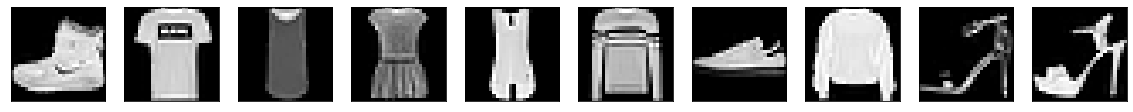

In [11]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(1, number, index + 1)
    plt.imshow(x_train[index], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 모델

In [17]:
class VAE(tf.keras.Model):
    
    def __init__(self, h_dim, z_dim, image_size, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        # for encoder : input -> fc1 -> fc2, mu
        #                            -> fc3, sigma
        self.fc1 = tf.keras.layers.Dense(h_dim, activation='relu')
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)
        
        # for decoder : z (from reparameterization) -> fc4 -> fc5 
        self.fc4 = tf.keras.layers.Dense(h_dim, activation='relu')
        self.fc5 = tf.keras.layers.Dense(image_size)
        
        
    def encode(self, x):
        x = self.fc1(x)
        return self.fc2(x), self.fc3(x)
    
    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(std.shape)
        z = mu + eps * std
        return z
    
    def decode_logits(self,z):
        x = self.fc4(z)
        logits = self.fc5(x)
        return logits
    
    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))
    
    def call(self, inputs):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        logits = self.decode_logits(z)
        return logits, mu, log_var
    
model = VAE(hidden_dim, latent_dim, image_size)
model.build(input_shape=(4, image_size))
model.summary()

Model: "vae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              multiple                  401920    
_________________________________________________________________
dense_6 (Dense)              multiple                  5130      
_________________________________________________________________
dense_7 (Dense)              multiple                  5130      
_________________________________________________________________
dense_8 (Dense)              multiple                  5632      
_________________________________________________________________
dense_9 (Dense)              multiple                  402192    
Total params: 820,004
Trainable params: 820,004
Non-trainable params: 0
_________________________________________________________________


# 학습

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate)
num_batches = x_train.shape[0] // batch_size

for epoch in range(num_epochs):

    for step, x in enumerate(dataset):

        x = tf.reshape(x, [-1, image_size])

        with tf.GradientTape() as tape:

            # Forward pass
            x_reconstruction_logits, mu, log_var = model(x)

            # Compute reconstruction loss and kl divergence
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / batch_size
            kl_div = - 0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            # Backprop and optimize
            loss = tf.reduce_mean(reconstruction_loss) + kl_div

        gradients = tape.gradient(loss, model.trainable_variables)
        for g in gradients:
            tf.clip_by_norm(g, 15)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if (step + 1) % 200 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                  .format(epoch + 1, num_epochs, step + 1, num_batches, float(reconstruction_loss), float(kl_div)))

Epoch[1/80], Step [200/600], Reconst Loss: 271.4844, KL Div: 14.3124
Epoch[1/80], Step [400/600], Reconst Loss: 264.7756, KL Div: 13.9617
Epoch[1/80], Step [600/600], Reconst Loss: 236.6939, KL Div: 14.9260
Epoch[2/80], Step [200/600], Reconst Loss: 238.6734, KL Div: 13.5730
Epoch[2/80], Step [400/600], Reconst Loss: 243.6610, KL Div: 15.0059
Epoch[2/80], Step [600/600], Reconst Loss: 229.7968, KL Div: 15.4499
Epoch[3/80], Step [200/600], Reconst Loss: 241.0036, KL Div: 14.8772
Epoch[3/80], Step [400/600], Reconst Loss: 221.8995, KL Div: 15.2210
Epoch[3/80], Step [600/600], Reconst Loss: 213.9315, KL Div: 15.3640
Epoch[4/80], Step [200/600], Reconst Loss: 245.7823, KL Div: 14.6570
Epoch[4/80], Step [400/600], Reconst Loss: 244.6368, KL Div: 16.4599
Epoch[4/80], Step [600/600], Reconst Loss: 229.6854, KL Div: 15.2570
Epoch[5/80], Step [200/600], Reconst Loss: 230.2720, KL Div: 15.1150
Epoch[5/80], Step [400/600], Reconst Loss: 240.2941, KL Div: 14.6803
Epoch[5/80], Step [600/600], Recon

Epoch[40/80], Step [400/600], Reconst Loss: 217.8890, KL Div: 15.4634
Epoch[40/80], Step [600/600], Reconst Loss: 231.4492, KL Div: 15.3385
Epoch[41/80], Step [200/600], Reconst Loss: 223.6555, KL Div: 16.3097
Epoch[41/80], Step [400/600], Reconst Loss: 221.7516, KL Div: 14.7855
Epoch[41/80], Step [600/600], Reconst Loss: 224.7079, KL Div: 15.4332
Epoch[42/80], Step [200/600], Reconst Loss: 225.6893, KL Div: 15.2672
Epoch[42/80], Step [400/600], Reconst Loss: 218.9330, KL Div: 13.7519
Epoch[42/80], Step [600/600], Reconst Loss: 223.7931, KL Div: 15.7622
Epoch[43/80], Step [200/600], Reconst Loss: 239.0128, KL Div: 15.0829
Epoch[43/80], Step [400/600], Reconst Loss: 223.2902, KL Div: 14.8383
Epoch[43/80], Step [600/600], Reconst Loss: 227.1059, KL Div: 15.5520
Epoch[44/80], Step [200/600], Reconst Loss: 234.1590, KL Div: 14.8435
Epoch[44/80], Step [400/600], Reconst Loss: 229.4859, KL Div: 15.3908
Epoch[44/80], Step [600/600], Reconst Loss: 225.2988, KL Div: 14.8021
Epoch[45/80], Step [

Epoch[79/80], Step [600/600], Reconst Loss: 208.1325, KL Div: 15.3041
Epoch[80/80], Step [200/600], Reconst Loss: 215.0269, KL Div: 15.0215
Epoch[80/80], Step [400/600], Reconst Loss: 231.7758, KL Div: 15.2618
Epoch[80/80], Step [600/600], Reconst Loss: 222.8456, KL Div: 15.5176


# 생성기로 활용

In [19]:
z = tf.random.normal((batch_size, latent_dim))
out = model.decode(z)  # decode with sigmoid
out = out.numpy() * 255
out = out.astype(np.uint8)

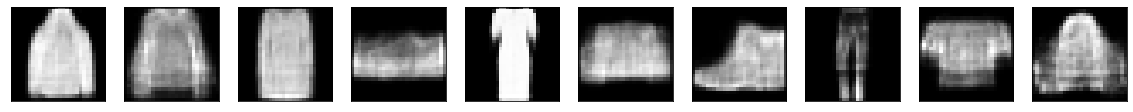

In [20]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(out[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()